In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate

plt.rcParams["figure.figsize"] = (8, 2)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 240
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


In [2]:
df = pd.read_csv("data/idle_current.csv")

df["Power"] = df["Voltage"] * df["Current"]
df.pivot(index="Voltage", columns="DUT", values=["Current", "Power"]).swaplevel(0, 1, axis=1).sort_index(axis=1)


DUT     4367 1883        5421 2569       
          Current  Power   Current  Power
Voltage                                  
15           10.8  162.0      10.8  162.0
16           10.2  163.2      10.2  163.2
17            9.8  166.6       9.7  164.9
18            9.3  167.4       9.3  167.4
19            8.9  169.1       8.9  169.1
20            8.6  172.0       8.5  170.0
21            8.2  172.2       8.2  172.2
22            7.9  173.8       7.8  171.6
23            7.5  172.5       7.5  172.5
24            7.2  172.8       7.2  172.8
25            6.9  172.5       6.9  172.5

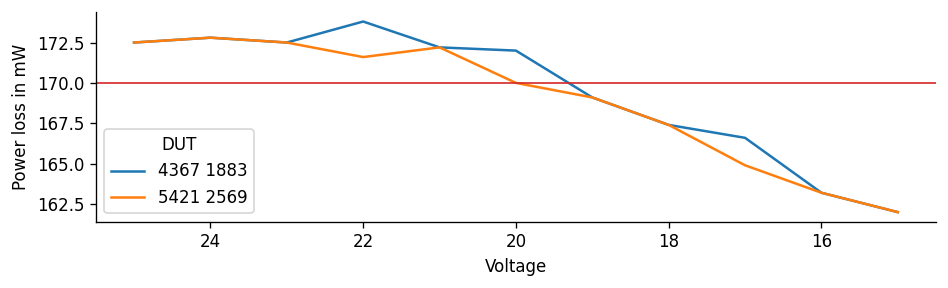

In [3]:
df.pivot(index="Voltage", columns="DUT", values="Power").plot(ylabel="Power loss in mW", figsize=(8, 2.5)).invert_xaxis()
plt.axhline(170, c="C3", lw=1)
plt.tight_layout()

In [4]:
un38_3 = pd.read_csv("../UN38.3/cycles.csv", index_col="cycle")

c25 = (
    pd.read_parquet(
        "../UN38.3/source.parquet",
        columns=["_time", "voltage", "current"],
        filters=[
            ("_time", ">", pd.Timestamp(un38_3.loc[25, "dsg_start"])),
            ("_time", "<", pd.Timestamp(un38_3.loc[25, "dsg_end"])),
        ],
    )
    .rename(columns={"_time": "time"})
    .set_index("time")
    .resample("1s")
    .mean()
)
c25["current"] /= -4
c25["power"] = c25["voltage"] * c25["current"]
c25["energy"] = integrate.cumulative_trapezoid(c25["power"], dx=1.0, initial=0) / 3600
c25["dVdE"] = c25.voltage.diff() / c25.energy.diff()
c25.loc[:"2024-10-25 12:47:37+00:00", "dVdE"] = float("NaN")

c25

,voltage,current,power,energy,dVdE
time,,,,,
2024-10-25 12:47:34+00:00,25.09198,2.219362,55.688199,0.000000,NaN
2024-10-25 12:47:35+00:00,24.58503,9.977327,245.292896,0.041803,NaN
2024-10-25 12:47:36+00:00,24.44118,12.005683,293.433047,0.116626,NaN
2024-10-25 12:47:37+00:00,24.42217,12.007320,293.244810,0.198109,NaN
2024-10-25 12:47:38+00:00,24.40676,12.005275,293.009866,0.279533,-0.189256
...,...,...,...,...,...
2024-10-25 13:43:50+00:00,15.20800,12.001185,182.514021,242.129984,-0.850315
2024-10-25 13:43:51+00:00,15.16461,11.999135,181.962203,242.180606,-0.857142
2024-10-25 13:43:52+00:00,15.12119,11.999955,181.453600,242.231080,-0.860238


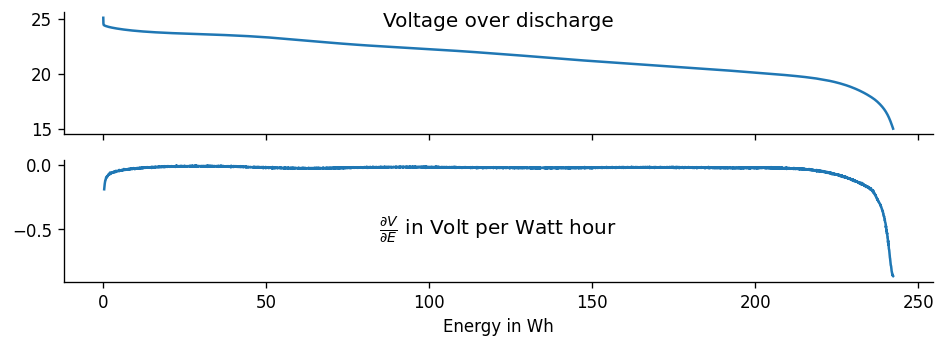

In [5]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axes[0].set_title("Voltage over discharge", y=0.8)
axes[0].plot(c25.energy, c25.voltage)
axes[1].set_title(r"$\frac{\partial V}{\partial E}$ in Volt per Watt hour", y=0.3)
axes[1].plot(c25.energy, c25.dVdE)

axes[1].set_xlabel("Energy in Wh")

plt.tight_layout()


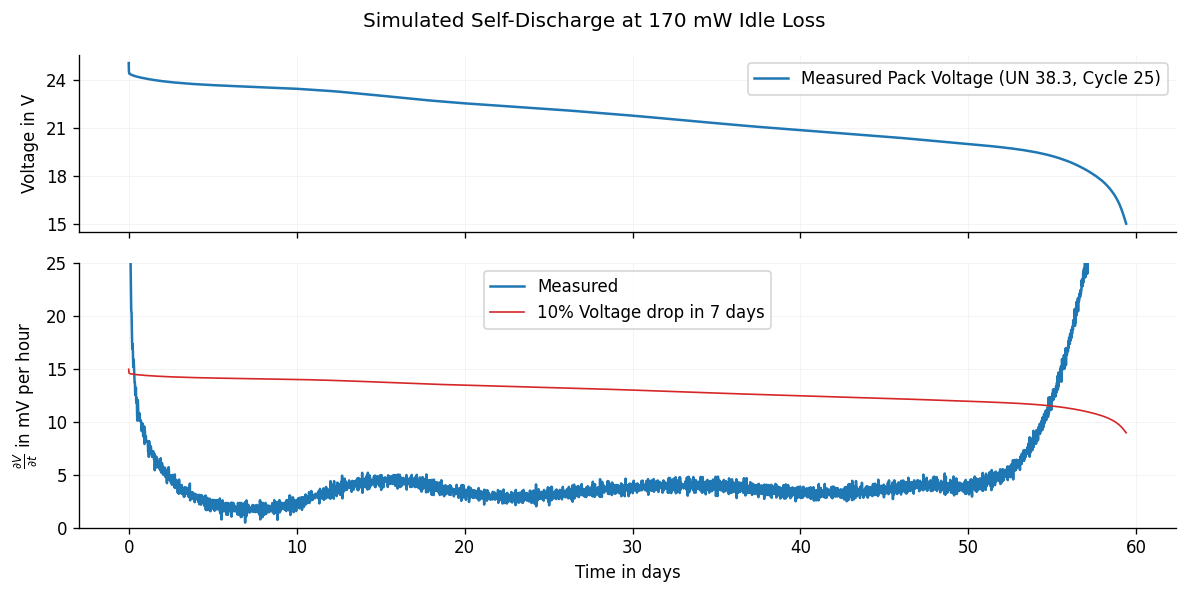

In [19]:
_average_power = 170e-3

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, height_ratios=[2, 3])
fig.suptitle(f"Simulated Self-Discharge at {_average_power * 1000:.0f} mW Idle Loss")

t = c25.energy / _average_power / 24

axes[0].plot(t, c25.voltage, label="Measured Pack Voltage (UN 38.3, Cycle 25)")
axes[0].set_ylabel("Voltage in V")
axes[0].legend()
axes[0].set_yticks([15, 18, 21, 24])

axes[1].plot(t, -c25.dVdE * _average_power * 1000, label="Measured")
axes[1].plot(t, c25.voltage * 0.1 / 24 / 7 * 1000, c="C3", lw=1, label="10% Voltage drop in 7 days")
axes[1].set_ylim(0, 25)
axes[1].set_ylabel(r"$\frac{\partial V}{\partial t}$ in mV per hour")
axes[1].set_xlabel("Time in days")
axes[1].legend()

for ax in axes:
    ax.grid(color="0.95", lw=0.5)

fig.tight_layout()
fig.savefig("img/self-discharge.png")
